In [32]:
import pandas as pd

df = pd.read_csv("../data/raw/nfcs_2021.csv")
print("Original shape:", df.shape)
df.head()


Original shape: (27118, 126)


,NFCSID,STATEQ,CENSUSDIV,CENSUSREG,A50A,A3Ar_w,A50B,A4A_new_w,A5_2015,A6,...,M6,M7,M8,M31,M50,M9,M10,wgt_n2,wgt_d2,wgt_s3
0,2021010001,41,5,3,2,2,8,1,6,1,...,1,3,2,2,2,1,2,0.834316,0.539386,0.725252
1,2021010002,36,3,2,2,2,8,1,6,4,...,98,98,98,98,98,1,98,1.083618,1.075806,0.930410
2,2021010003,3,8,4,1,6,6,1,6,4,...,1,3,98,3,1,1,2,0.396368,2.123406,0.944175
3,2021010004,3,8,4,2,4,10,2,2,1,...,1,98,98,1,1,1,2,0.374328,2.372112,1.011643
4,2021010005,36,3,2,2,4,10,1,3,4,...,1,98,98,98,98,98,98,1.362034,1.159651,0.907194


In [33]:
df = df[df["J50"] == 1].copy()
print("After filtering stimulus recipients:", df.shape)


After filtering stimulus recipients: (21371, 126)


In [35]:
# Columns that represent stimulus use categories
label_cols = ["J51_1", "J51_2", "J51_3"]

# Convert to numeric (handle bad string values like ' '), fill NaN with 0, then cast to int
df[label_cols] = df[label_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)


In [36]:
df = df[df[label_cols].sum(axis=1) == 1].copy()

# Create label column
def map_label(row):
    if row["J51_1"] == 1:
        return "spender"
    elif row["J51_2"] == 1:
        return "saver"
    elif row["J51_3"] == 1:
        return "debtor"

df["label"] = df.apply(map_label, axis=1)

# Confirm
print("✅ Valid labeled responses:", df.shape)
print(df["label"].value_counts())


✅ Valid labeled responses: (13557, 127)
label
spender    6592
debtor     4398
saver      2567
Name: count, dtype: int64


In [37]:
selected_features = [
    "A6",         # age
    "A3Ar_w",     # race
    "A50A",       # gender
    "A4A_new_w",  # education
    "A9",         # marital status
    "J1",         # financial satisfaction
    "J2",         # difficulty covering expenses
    "J20",        # income drop
]

df = df[selected_features + ["label"]].copy()
print(df.shape)
df.head()


(13557, 9)


,A6,A3Ar_w,A50A,A4A_new_w,A9,J1,J2,J20,label
2,4,6,1,1,8,10,7,1,debtor
6,1,5,2,1,8,99,99,99,spender
7,1,2,2,1,2,3,2,2,debtor
8,4,6,2,1,8,5,3,4,saver
11,1,6,1,1,8,10,7,1,debtor


In [38]:
df = df.dropna()
print("After dropping missing:", df.shape)


After dropping missing: (13557, 9)


In [39]:
categorical_cols = ["A3Ar_w", "A50A", "A4A_new_w", "A9"]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df.head()


,A6,J1,J2,J20,label,A3Ar_w_2,A3Ar_w_3,A3Ar_w_4,A3Ar_w_5,A3Ar_w_6,A50A_2,A4A_new_w_2,A9_2,A9_3,A9_4,A9_5,A9_6,A9_7,A9_8
2,4,10,7,1,debtor,False,False,False,False,True,False,False,False,False,False,False,False,False,True
6,1,99,99,99,spender,False,False,False,True,False,True,False,False,False,False,False,False,False,True
7,1,3,2,2,debtor,True,False,False,False,False,True,False,True,False,False,False,False,False,False
8,4,5,3,4,saver,False,False,False,False,True,True,False,False,False,False,False,False,False,True
11,1,10,7,1,debtor,False,False,False,False,True,False,False,False,False,False,False,False,False,True


In [40]:
df.to_csv("../data/processed/stimulus_cleaned.csv", index=False)
print("✅ Saved to ../data/processed/stimulus_cleaned.csv")


✅ Saved to ../data/processed/stimulus_cleaned.csv


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset from processed folder
df = pd.read_csv("../data/processed/stimulus_cleaned.csv")


Matplotlib is building the font cache; this may take a moment.


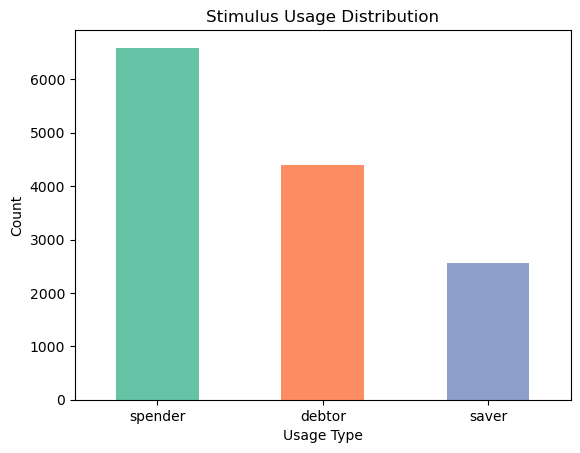

In [42]:
df["label"].value_counts().plot(kind="bar", color=["#66c2a5", "#fc8d62", "#8da0cb"])
plt.title("Stimulus Usage Distribution")
plt.xlabel("Usage Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


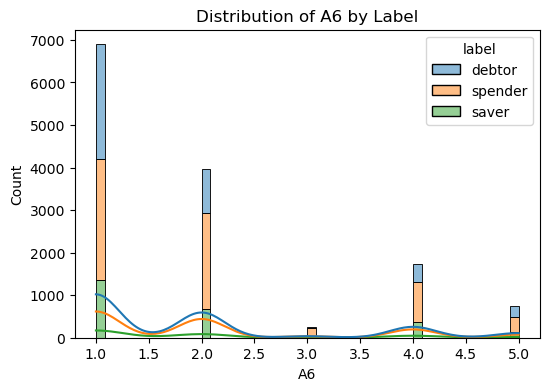

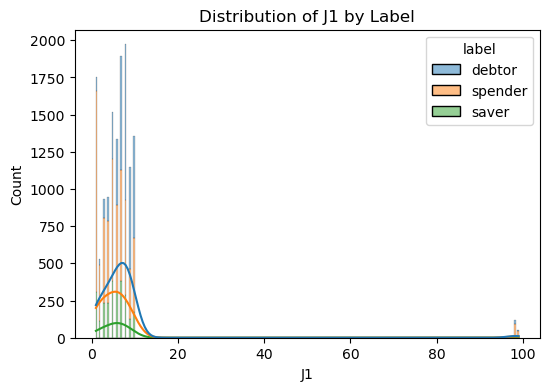

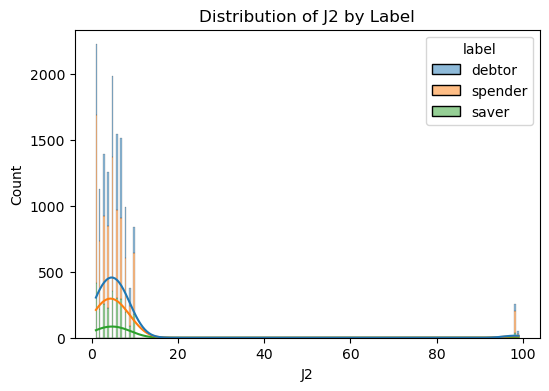

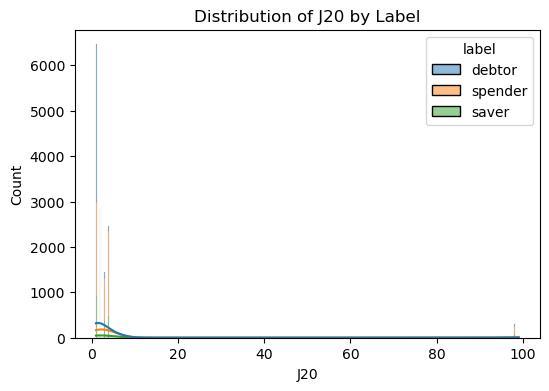

In [43]:
numeric_cols = ["A6", "J1", "J2", "J20"]

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, kde=True, hue="label", multiple="stack")
    plt.title(f"Distribution of {col} by Label")
    plt.show()


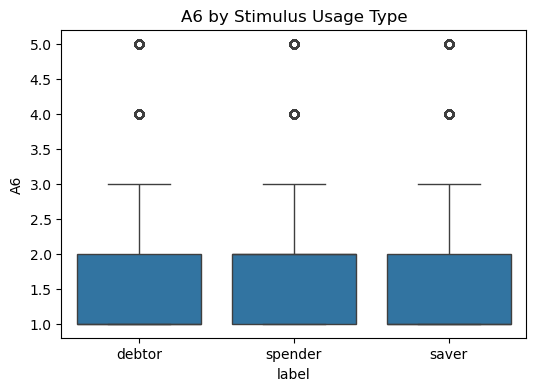

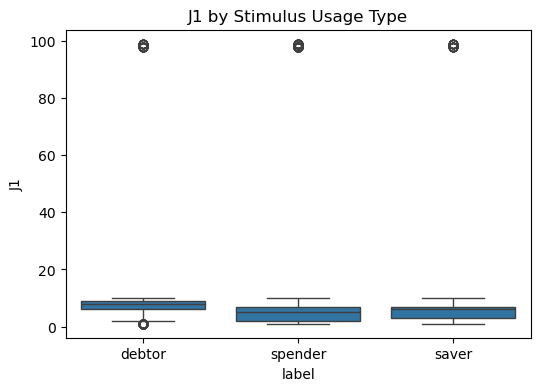

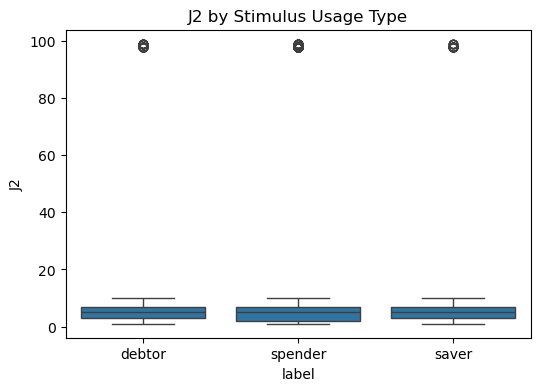

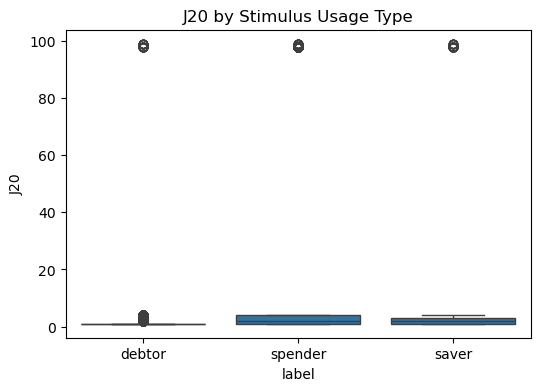

In [44]:
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x="label", y=col)
    plt.title(f"{col} by Stimulus Usage Type")
    plt.show()


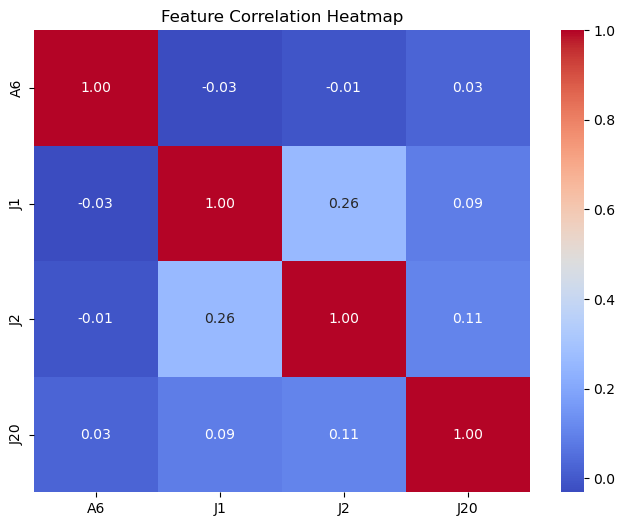

In [45]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


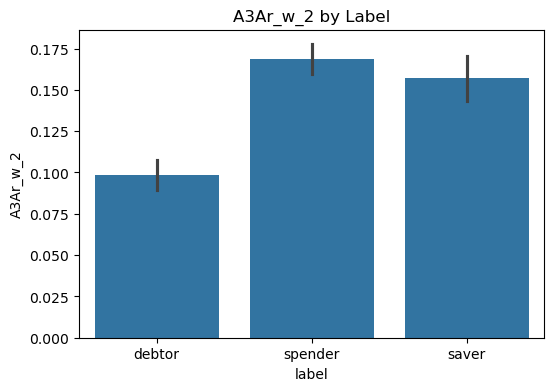

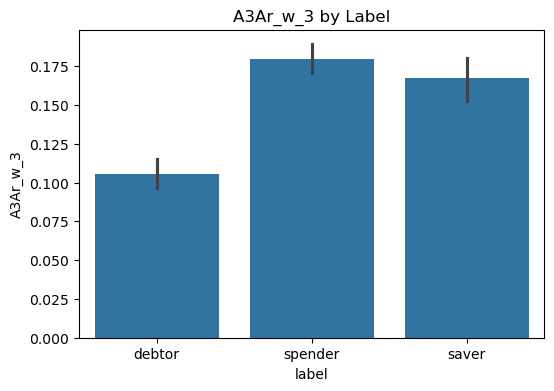

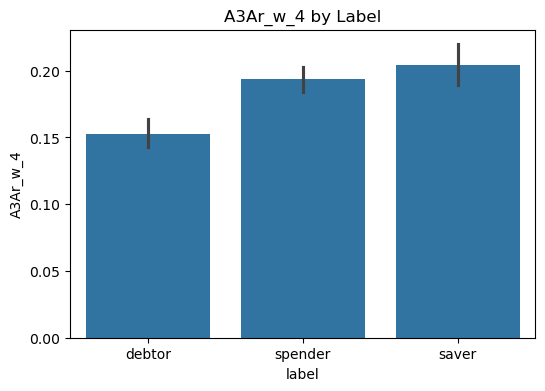

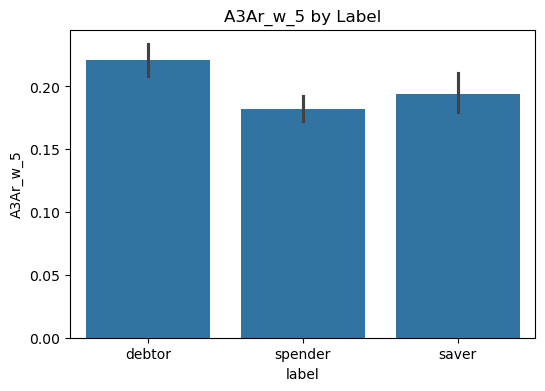

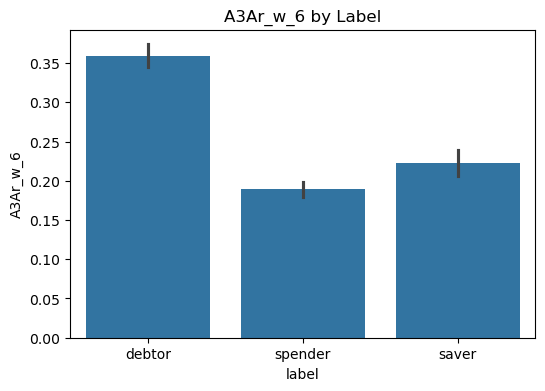

In [46]:
race_cols = [col for col in df.columns if col.startswith("A3Ar_w")]

for col in race_cols:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=df, x="label", y=col)
    plt.title(f"{col} by Label")
    plt.show()
